<a href="https://colab.research.google.com/github/RichardMWarburton/ExploringCUAD/blob/Dev/Bag%20of%20Clauses%20Build.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Building a Bag of Clauses

## 1: Import Packages & Define Useful Functions

In [1]:
from zipfile import ZipFile
import json
import os
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import re
from random import sample, choice
import numpy as np
import pandas as pd
import re
import string
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN, KMeans
from sklearn.cluster import AgglomerativeClustering
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

!pip install dateparser
import dateparser

!pip install num2words
from num2words import num2words

import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 279 kB 29.0 MB/s 
     |████████████████████████████████| 101 kB 8.8 MB/s 


In [2]:
def extract_zip(pth,data_pth = None):
    """Function to extract contents of a zip file to a specified location (wd if data_pth not passed)"""
    with ZipFile(pth, 'r') as zipObj:
       # Extract all the contents of zip file in different directory
       zipObj.extractall(data_pth)

In [3]:
def lower_case(x):
  """Function to return a lowecase value of a string x"""
  return x.lower()

In [4]:
def remove_stop_words(x):
  """Function to remove stop words from a string x """  
  return ' '.join([word for word in x.split(sep=' ') if word not in stop_words])

In [5]:
def coerce_tokens(x):
  ret = x.replace('new york','newyork')
  ret = ret.replace('new jersey','newjersey')
  ret = ret.replace('hong kong','hongkong')
  ret = ret.replace('san antonio','sanantonio')
  return ret

In [6]:
def append_type_match(x, value_list,matches=[]):
  if x.label_ in matches:
    value_list.append(x)

In [7]:
def ordinalize_num(txt):
  for token in txt.split(sep=' '):
    try:
      if int(token) <= 31:
        ord_val = num2words(token, lang="en", to="ordinal_num")
        txt = txt.replace(token,ord_val)
    except:
      continue
  return txt

## 2: Download repository and extract data

### 2.1: Extract Raw Contract Data

In [8]:
#Download CUAD git repository
if not os.path.exists('main.zip'):
  !wget --no-check-certificate https://github.com/TheAtticusProject/cuad/archive/refs/heads/main.zip
  !unzip -q main.zip

#If it has not already been extracted, extract the contents of data.zip
if not os.path.exists('cuad-main/data'):
  os.makedirs('cuad-main/data')

if not os.path.exists('cuad-main/data/CUADv1.json'):
  extract_zip('cuad-main/data.zip','cuad-main/data/')

#Download a manualy curated set of labels for the full CUAD data. 
if not os.path.exists('labels3.txt'):
  !wget https://raw.githubusercontent.com/RichardMWarburton/ExploringCUAD/main/labels3.txt

--2021-07-20 16:00:19--  https://github.com/TheAtticusProject/cuad/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/TheAtticusProject/cuad/zip/refs/heads/main [following]
--2021-07-20 16:00:19--  https://codeload.github.com/TheAtticusProject/cuad/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.114.10
Connecting to codeload.github.com (codeload.github.com)|140.82.114.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [  <=>               ]  17.77M  22.1MB/s    in 0.8s    

2021-07-20 16:00:20 (22.1 MB/s) - ‘main.zip’ saved [18631176]

--2021-07-20 16:00:21--  https://raw.githubusercontent.com/RichardMWarburton/ExploringCUAD/main/labels3.txt
Resolving raw.githubusercont

In [9]:
#Load CUADv1 JSON to data
with open('cuad-main/data/CUADv1.json','r') as infile:
    for line in infile:
        contract_data = json.loads(line)

In [10]:
#ser reg ex expression for characters to remove from contract contest
spec_chars = '\\n|\\t|\\t'

#Set number of contracts in data
num_contracts = len(contract_data['data'])

#Initate dictionary to store raw contract data
raw_contracts = defaultdict(list)

#for each contract
for i in range(num_contracts):
  #Append the title, contract text and character length of text to the raw_contracts dictionary
  raw_contracts['contract title'].append(contract_data['data'][i]['title'])
  #raw_contracts['label'].append(labels_LU[contract_data['data'][i]['title']] if contract_data['data'][i]['title'] in labels_LU else 'marketing agreement' ) #<- manual error trap applied here (see below)
  
  #Parse raw text and process to remove breaks
  raw_text = contract_data['data'][i]['paragraphs'][0]['context']
  clean_text = re.sub(spec_chars,'',raw_text)

  #Split clean text in to sentances and tokens
  sentance_text = clean_text.split(sep = '. ')
  token_text = clean_text.split(sep = ' ')

  #Append text to the respective key in the raw_contracts dictionary
  raw_contracts['raw text'].append(raw_text)
  raw_contracts['clean text'].append(clean_text)
  raw_contracts['sentance text'].append(sentance_text)
  raw_contracts['token text'].append(token_text)
  
  #Add character, sentance and token counts to raw_contracts dictionary
  raw_contracts['character count'].append(len(raw_text))
  raw_contracts['sentance count'].append(len(sentance_text))
  raw_contracts['token count'].append(len(token_text))

### 2.2: Extract Clause Specific Data

In [11]:
#Define the number of clauses
num_clauses = 41

#initate dictioanry to store caluse data
clause_data = defaultdict(list)

#For each contract
for i in range(num_contracts):
  #for each clause
  for j in range(num_clauses):
    #for each found clause annotation
    for k in range(len(contract_data['data'][i]['paragraphs'][0]['qas'][j]['answers'])): 
      #Add the contract title
      clause_data['contract title'].append(contract_data['data'][i]['title'])
      #clause_data['label'].append(labels_LU[contract_data['data'][i]['title']] if contract_data['data'][i]['title'] in labels_LU else 'marketing agreement' )  #<- manual error trap applied here
      clause_data['clause'].append(contract_data['data'][i]['paragraphs'][0]['qas'][j]['id'].split(sep='__')[1])
      clause_data['annotation'].append(contract_data['data'][i]['paragraphs'][0]['qas'][j]['answers'][k]['text'])
      clause_data['annotation start'].append(contract_data['data'][i]['paragraphs'][0]['qas'][j]['answers'][k]['answer_start'])
      clause_data['annotation length'].append(len(contract_data['data'][i]['paragraphs'][0]['qas'][j]['answers'][k]['text']))


### 2.3: Cleaning Data

In [12]:
#Initate dataframe of all clause data
clause_df = pd.DataFrame(clause_data)

#Convert to lower case
#clause_df['annotation'] = clause_df['annotation'].apply(lambda x: x.lower())

#Remove any formating characters or multiple spaces and replace with a single space
clause_df['annotation'] = clause_df['annotation'].apply(lambda x: re.sub('\\t|\\r|\\n|[^\S]{2,}',' ',x))

#Remove punctuation from the string
clause_df['annotation'] = clause_df['annotation'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

## 3: Bag of Clauses

In [13]:
#Initate Bag of Clauses.
bag_of_clauses = defaultdict(dict)

#For each contract:
for contract in np.unique(clause_df['contract title'].values):
  idx = clause_df['contract title'] == contract
  for clause in np.unique(clause_df[idx]['clause']):
    bag_of_clauses[contract][clause] = np.nan

bag_of_clauses['XYBERNAUTCORP_07_12_2002-EX-4-SPONSORSHIP AGREEMENT']

{'Agreement Date': nan,
 'Anti-Assignment': nan,
 'Cap On Liability': nan,
 'Document Name': nan,
 'Exclusivity': nan,
 'Expiration Date': nan,
 'Governing Law': nan,
 'License Grant': nan,
 'Non-Disparagement': nan,
 'Non-Transferable License': nan,
 'Parties': nan}

### 3.1 Add 'Governeing Law' To BoC

In [14]:
#Define clause of interest
clause_of_interest = 'Governing Law'

#Limit df to clause of interest and extract annotations of itnerest
of_interest_data = clause_df[clause_df['clause'] == clause_of_interest]
annotations_of_interest = of_interest_data['annotation'].values

#Identify where there are multiple annotations per contract
titles,counts = np.unique(of_interest_data['contract title'],return_counts =True)
dups = titles[counts >= 2]

#Output Analysis
print('There are {} contracts with \'{}\' annotations'.format(*(titles.shape[0],clause_of_interest)))
print('There are {} contracts with more than one annotation'.format(dups.shape[0]))

#output duplicate annotations anc contract titles
dup_df = of_interest_data[of_interest_data['contract title'].isin(dups)][['contract title','annotation']]

There are 437 contracts with 'Governing Law' annotations
There are 25 contracts with more than one annotation


In [15]:
#Initate memory for annotations within contracts
combined_annotations_list = defaultdict(list)
combined_annotations_string = {}

#For each annotation of interest found in the contract, 
for i in of_interest_data.index:
  #Append annotation to a default dict list with contract as key
  name = of_interest_data.loc[i,['contract title']].values[0]
  annotation = of_interest_data.loc[i,['annotation']].values[0]
  combined_annotations_list[name].append(annotation) #<- coerces duplicate annotations in to a single string

#Produce a single string of all annotations found in specific contracts
for key in combined_annotations_list.keys():
  combined_annotations_string[key] = ' '.join(combined_annotations_list[key])

In [16]:
#Build array of contract names and concatenated annotations
contracts = np.array(list(combined_annotations_string.keys()))
combined_annotations = list(combined_annotations_string.values())

#### 3.1.1 Extract Governing Law via named entity recognition

In [17]:
#Define stopwords list
stop_words = stopwords.words('english') +['hereof','thereof']

nlp = en_core_web_sm.load()

#Build new features
new_features = []

for annotation in combined_annotations:
  annotation_GPEs = []
  
  doc = nlp(annotation)

  for X in doc.ents:
    #First pass to capture entities
    if X.label_ == 'GPE' or X.label_ == 'LANGUAGE':
      if X.text not in annotation_GPEs:
        annotation_GPEs.append(X.text)
  
  #If no entities found, foce to lower case and re analyise
  if annotation_GPEs == []:
    doc = nlp(annotation.lower())

    for X in doc.ents:
      if X.label_ == 'GPE' or X.label_ == 'LANGUAGE':
        if X.text not in annotation_GPEs:
          annotation_GPEs.append(X.text)

  new_features.append(' '.join(annotation_GPEs))

In [18]:
#initiate new_features as an np array
new_features = np.array(new_features)

#Clean New Features
new_features = np.array(list(map(lower_case,new_features)))
new_features = np.array(list(map(remove_stop_words,new_features)))
new_features = np.array(list(map(coerce_tokens,new_features)))

#Tokenize new_features
#new_features = np.array(list((map(nltk.word_tokenize,new_features))),dtype=object)

#Count Vectorize new_feature vector
cv = CountVectorizer(stop_words = 'english')
vectorized_features = cv.fit_transform(new_features).toarray()

In [19]:
#Add Vectorization to BoC
for i in range(len(contracts)):
  bag_of_clauses[contracts[i]][clause_of_interest] = vectorized_features[i,:]

### 3.1 Add 'Agreement Date' To BoC

In [20]:
#Define clause of interest
clause_of_interest = 'Agreement Date'

#Limit df to clause of interest and extract annotations of itnerest
of_interest_data = clause_df[clause_df['clause'] == clause_of_interest]
annotations_of_interest = of_interest_data['annotation'].values

#Identify where there are multiple annotations per contract
titles,counts = np.unique(of_interest_data['contract title'],return_counts =True)
dups = titles[counts >= 2]

#Output Analysis
print('There are {} contracts with \'{}\' annotations'.format(*(titles.shape[0],clause_of_interest)))
print('There are {} contracts with more than one annotation'.format(dups.shape[0]))

There are 470 contracts with 'Agreement Date' annotations
There are 6 contracts with more than one annotation


In [21]:
#Initate memory for annotations within contracts
combined_annotations_list = defaultdict(list)
combined_annotations_string = {}

#For each annotation of interest found in the contract, 
#append annotation to a default dict list with contract as key
for i in of_interest_data.index:
  name = of_interest_data.loc[i,['contract title']].values[0]
  annotation = of_interest_data.loc[i,['annotation']].values[0]
  combined_annotations_list[name].append(annotation)

#Produce a singel string of all annotations found in specific contracts
for key in combined_annotations_list.keys():
  combined_annotations_string[key] = ' '.join(combined_annotations_list[key])

#Build array of contract names and concatenated annotations
contracts = np.array(list(combined_annotations_string.keys()))
combined_annotations = np.array(list(combined_annotations_string.values()))

In [22]:
date_feature_list = []
not_mapped = []

nlp = en_core_web_sm.load()

for annotation in combined_annotations:

  annotation_list = []  
  #Clean annotaiton (typos etc)
  annotation = annotation.replace('  ',' ')
  annotation = ' '.join([word for word in annotation.split(sep=' ') if word not in stop_words])
  annotation = annotation.replace('t h','th')
  annotation = annotation.replace('s t','st')
  annotation = annotation.replace('day','')
  annotation = ordinalize_num(annotation)

  doc = nlp(repr(annotation))

  for X in doc.ents:
    if X.label_ in ['DATE']:
      annotation_list.append(X.text)
    else:
      annotation_list.append(X.text)
      not_mapped.append(annotation)

  date_feature_list.append(' '.join(annotation_list))

In [23]:
pass_vals = list(map(dateparser.parse,date_feature_list))
matched = sum(list(map(lambda x: 1 if x == None else 0,pass_vals)))
print('Pass 1: {} of {} not matched ({:.2%})'.format(*(matched,len(pass_vals),matched/len(pass_vals))))

Pass 1: 66 of 470 not matched (14.04%)


In [24]:
#Remove any years significantly in the future (assumed errors)
for i in range(len(pass_vals)):
  if pass_vals[i] != None:
    if pass_vals[i].year >2025:
      print(pass_vals[i])
      pass_vals[i] = None

9997-07-20 00:00:00
3411-07-20 00:00:00
7798-07-20 00:00:00
8410-07-20 00:00:00


In [25]:
for i in range(len(contracts)):
  if pass_vals[i] != None:
    bag_of_clauses[contracts[i]][clause_of_interest] = pass_vals[i].timestamp()

In [26]:
bag_of_clauses['XYBERNAUTCORP_07_12_2002-EX-4-SPONSORSHIP AGREEMENT']

{'Agreement Date': 1020211200.0,
 'Anti-Assignment': nan,
 'Cap On Liability': nan,
 'Document Name': nan,
 'Exclusivity': nan,
 'Expiration Date': nan,
 'Governing Law': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0]),
 'License Grant': nan,
 'Non-Disparagement': nan,
 'Non-Transferable License': nan,
 'Parties': nan}

### 3.2 Expiration Date

In [27]:
clause_data['clause'] == 'Audit Rights'

False

In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer

ar = clause_df[clause_df['clause'] == 'Audit Rights']['annotation'].values

X = list(map(lambda x: x.lower(),ar))
                                                          

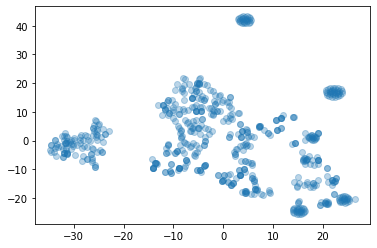

In [63]:
vectorizer = TfidfVectorizer(stop_words='english',max_features = 10)
vectorized_features = vectorizer.fit_transform(X).toarray()

#Reduce dimension wiht TSNE to 2D
X_tsne = TSNE(n_components=2).fit_transform(vectorized_features)
x = X_tsne[:,0]
y = X_tsne[:,1]

plt.scatter(x,y, alpha = 0.3)
plt.show()

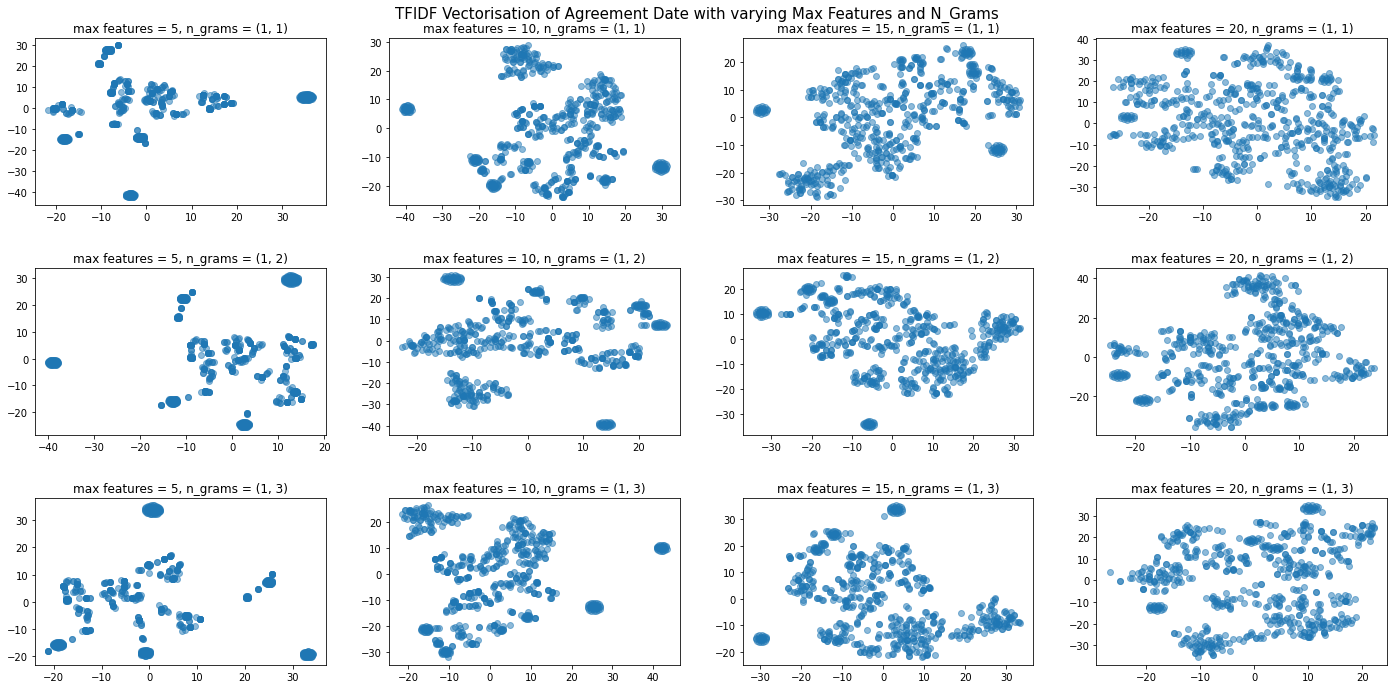

In [66]:
#Define max feature and n_gram ranges
max_features = [5,10,15,20]
n_grams = [(1,1),(1,2),(1,3)]

#Initate plot
fig, axs = plt.subplots(len(n_grams),len(max_features), figsize = (20,10))

#For each pair of max_features and n_grams
for i in range(len(max_features)):
  for j in range(len(n_grams)):

    #TFIDF vectorize the annotation
    vectorizer = TfidfVectorizer(ngram_range = n_grams[j],stop_words ='english',max_features=max_features[i])
    Xx = vectorizer.fit_transform(X).toarray() 

    #Reduce dimension wiht TSNE to 2D
    X_tsne = TSNE(n_components=2).fit_transform(Xx)
    x = X_tsne[:,0]
    y = X_tsne[:,1]

    #Plot respective parameters
    axs[j,i].scatter(x, y, alpha = 0.5)
    axs[j,i].set_title('max features = {}, n_grams = {}'.format(*(max_features[i],n_grams[j])))

#Format plot
plt.tight_layout(pad=3.0)
plt.suptitle('TFIDF Vectorisation of {} with varying Max Features and N_Grams\n\n'.format(clause_of_interest),size = 15)
plt.show()